In [28]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import json
seed = 42

plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'

$$w' = w \cdot \frac{n/\lambda}{n/\lambda + 1} + w_p \cdot \frac{1}{n/\lambda + 1}$$

$$w' = \frac{w \cdot (n/\lambda) + w_p}{n/\lambda + 1}$$

In [27]:
def analyze_tree_path_values(model, max_trees=5):
    """Analyze leaf values along paths in the trees"""
    model_dump = model.dump_model()
    tree_stats = []
    
    for tree_idx, tree in enumerate(model_dump['tree_info'][:max_trees]):
        leaf_values = []
        
        def collect_leaf_values(node):
            if 'leaf_value' in node:
                leaf_values.append(node['leaf_value'])
            else:
                collect_leaf_values(node['left_child'])
                collect_leaf_values(node['right_child'])
        
        collect_leaf_values(tree['tree_structure'])
        
        stats = {
            'tree_idx': tree_idx,
            'leaf_std': np.std(leaf_values),
            'leaf_range': max(leaf_values) - min(leaf_values),
            'leaf_mean': np.mean(leaf_values)
        }
        tree_stats.append(stats)
    
    return tree_stats

def plot_leaf_stats(results):
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    for smooth, data in results.items():
        tree_indices = [s['tree_idx'] for s in data['tree_stats']]
        leaf_stds = [s['leaf_std'] for s in data['tree_stats']]
        leaf_ranges = [s['leaf_range'] for s in data['tree_stats']]
        
        axes[0].plot(tree_indices, leaf_stds, 
                    label=f'path_smooth={smooth} (loss={data["test_score"]:.4f})')
        axes[1].plot(tree_indices, leaf_ranges, 
                    label=f'path_smooth={smooth}')
    
    axes[0].set_xlabel('Tree Index')
    axes[0].set_ylabel('Leaf Value Standard Deviation')
    axes[0].set_title('Variation in Leaf Values Across Trees')
    axes[0].legend()
    
    axes[1].set_xlabel('Tree Index')
    axes[1].set_ylabel('Leaf Value Range')
    axes[1].set_title('Range of Leaf Values Across Trees')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()    

In [17]:
X, y = make_classification(
    n_samples=100000, n_features=10, n_classes=2, weights=[0.99, 0.01], random_state=seed
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed)

data = {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test} 

In [18]:
base_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.001,
    'feature_fraction': 0.5,
    'verbose': -1
}

# Create datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [59]:
smooth_values = [0, 10, 1e3, 1e6]

results = {}
for smooth in smooth_values:
    params = base_params.copy()
    params['path_smooth'] = smooth
    
    model = lgb.train(
        params, 
        train_data, 
        num_boost_round=100,
        valid_sets=[test_data]
    )

    df = model.trees_to_dataframe()
    
    # Analyze tree structures
    tree_stats = analyze_tree_path_values(model, max_trees=20)
    results[smooth] = {
        'tree_stats': tree_stats,
        'model': model,
        'test_score': model.best_score['valid_0']['binary_logloss'],
        'df': df
    }

In [54]:
df.columns

Index(['tree_index', 'node_depth', 'node_index', 'left_child', 'right_child',
       'parent_index', 'split_feature', 'split_gain', 'threshold',
       'decision_type', 'missing_direction', 'missing_type', 'value', 'weight',
       'count'],
      dtype='object')

In [60]:
for s in smooth_values:
    print(results[s]['test_score'])

0.06744699311832517
0.06745961970750167
0.06894253046277356
0.07473558586197819


In [65]:
df.head()

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S2,0-S1,None,Column_3,80.338203,-0.016706,<=,left,None,-4.123810,0.000000,80000
1,0,2,0-S2,0-L0,0-S3,0-S0,Column_3,0.100743,-0.124782,<=,left,None,-4.123850,1055.250000,67336
2,0,3,0-L0,None,None,0-S2,None,NaN,NaN,None,None,None,-4.123879,1020.583913,65124
3,0,3,0-S3,0-S7,0-S5,0-S2,Column_0,0.005872,-0.589871,<=,left,None,-4.123850,34.665100,2212
4,0,4,0-S7,0-S10,0-S8,0-S3,Column_3,0.000599,-0.110814,<=,left,None,-4.123850,11.017000,703


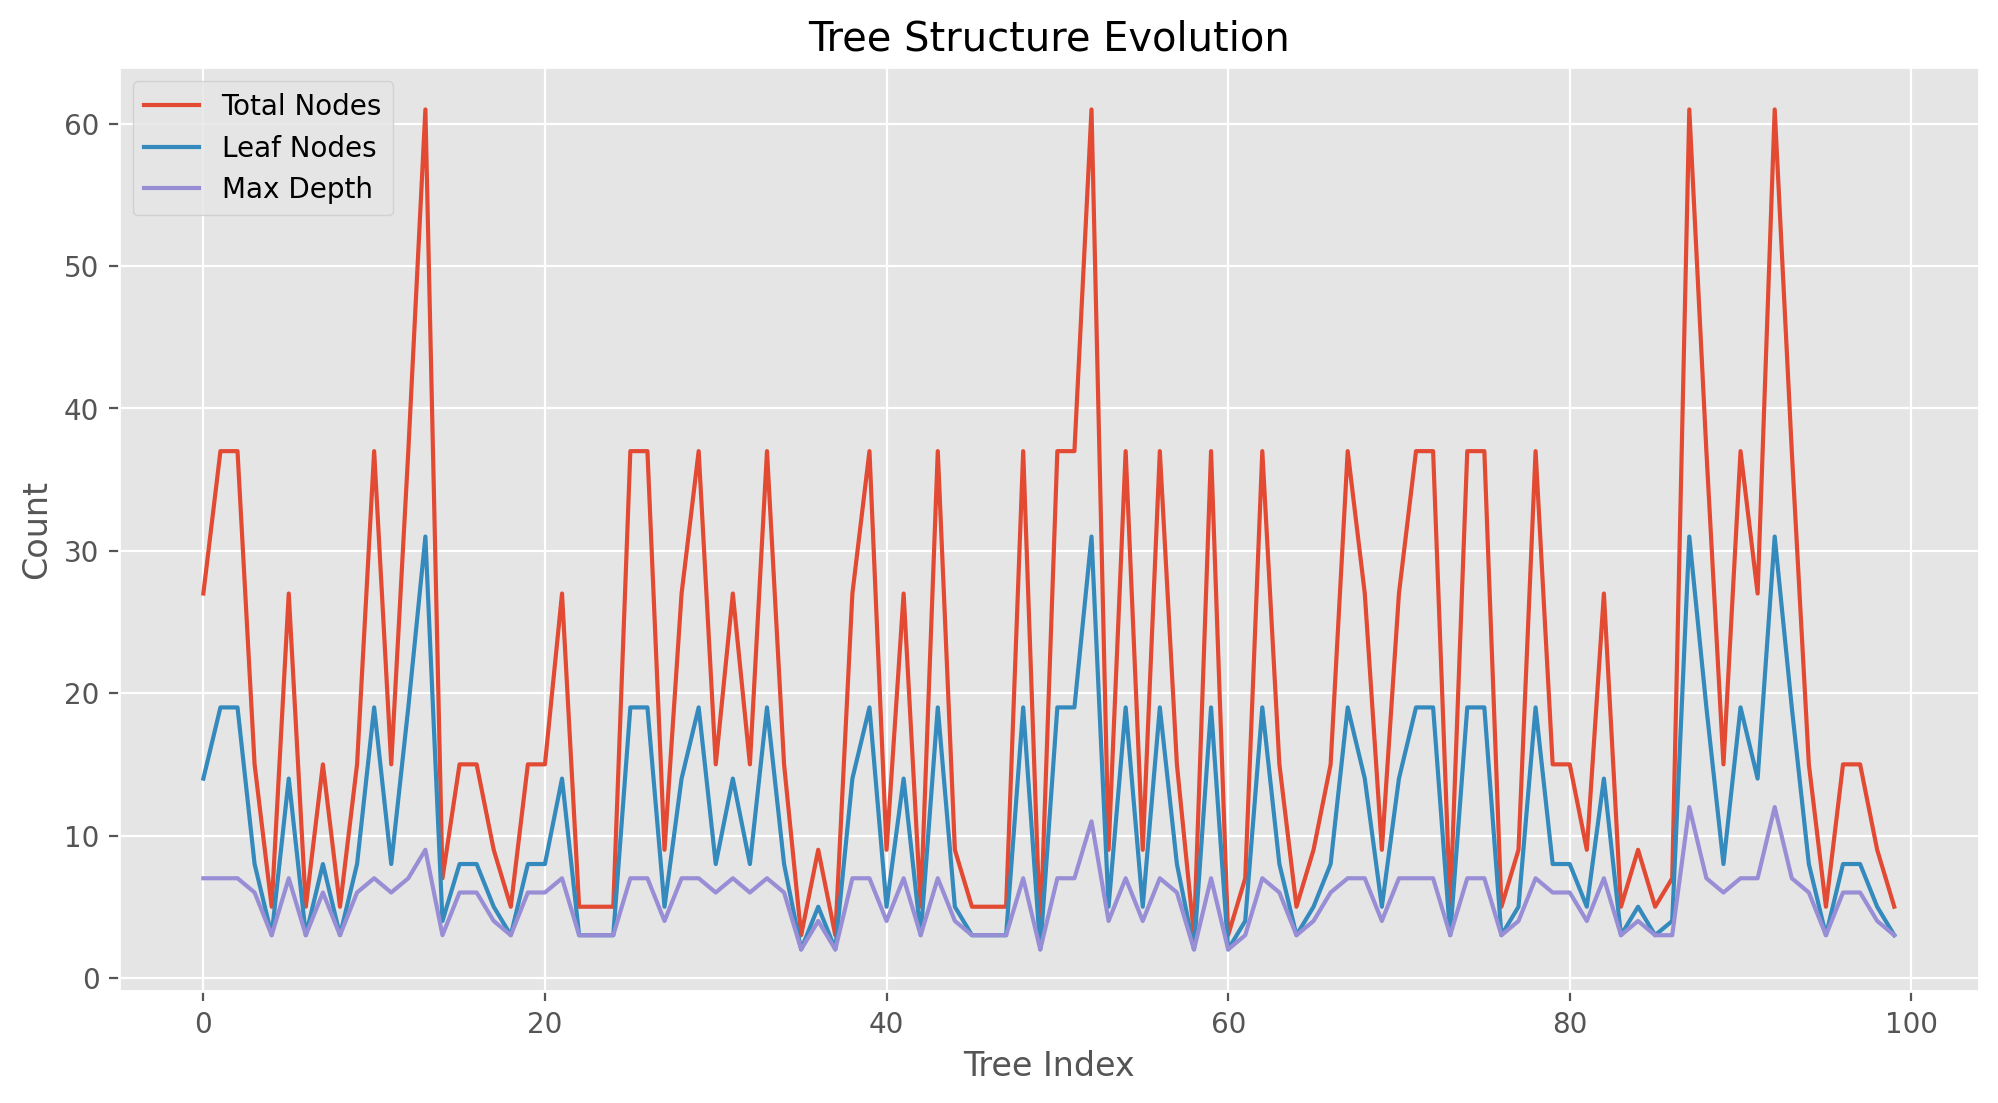

In [69]:
df_tree_stats = (df.groupby('tree_index')
                  .agg({
                      'node_depth': 'max',         # Max depth of the tree
                      'node_index': 'count',       # Total number of nodes
                      # Leaf nodes are those without children (left_child is NaN)
                      'left_child': lambda x: x.isna().sum()  # Number of leaf nodes
                  })
                  .reset_index())

plt.figure(figsize=(12, 6))
plt.plot(df_tree_stats['tree_index'], 
         df_tree_stats['node_index'], 
         label='Total Nodes')
plt.plot(df_tree_stats['tree_index'], 
         df_tree_stats['left_child'], 
         label='Leaf Nodes')
plt.plot(df_tree_stats['tree_index'], 
         df_tree_stats['node_depth'], 
         label='Max Depth')
plt.xlabel('Tree Index')
plt.ylabel('Count')
plt.title('Tree Structure Evolution')
plt.legend()
plt.grid(True)
plt.show()

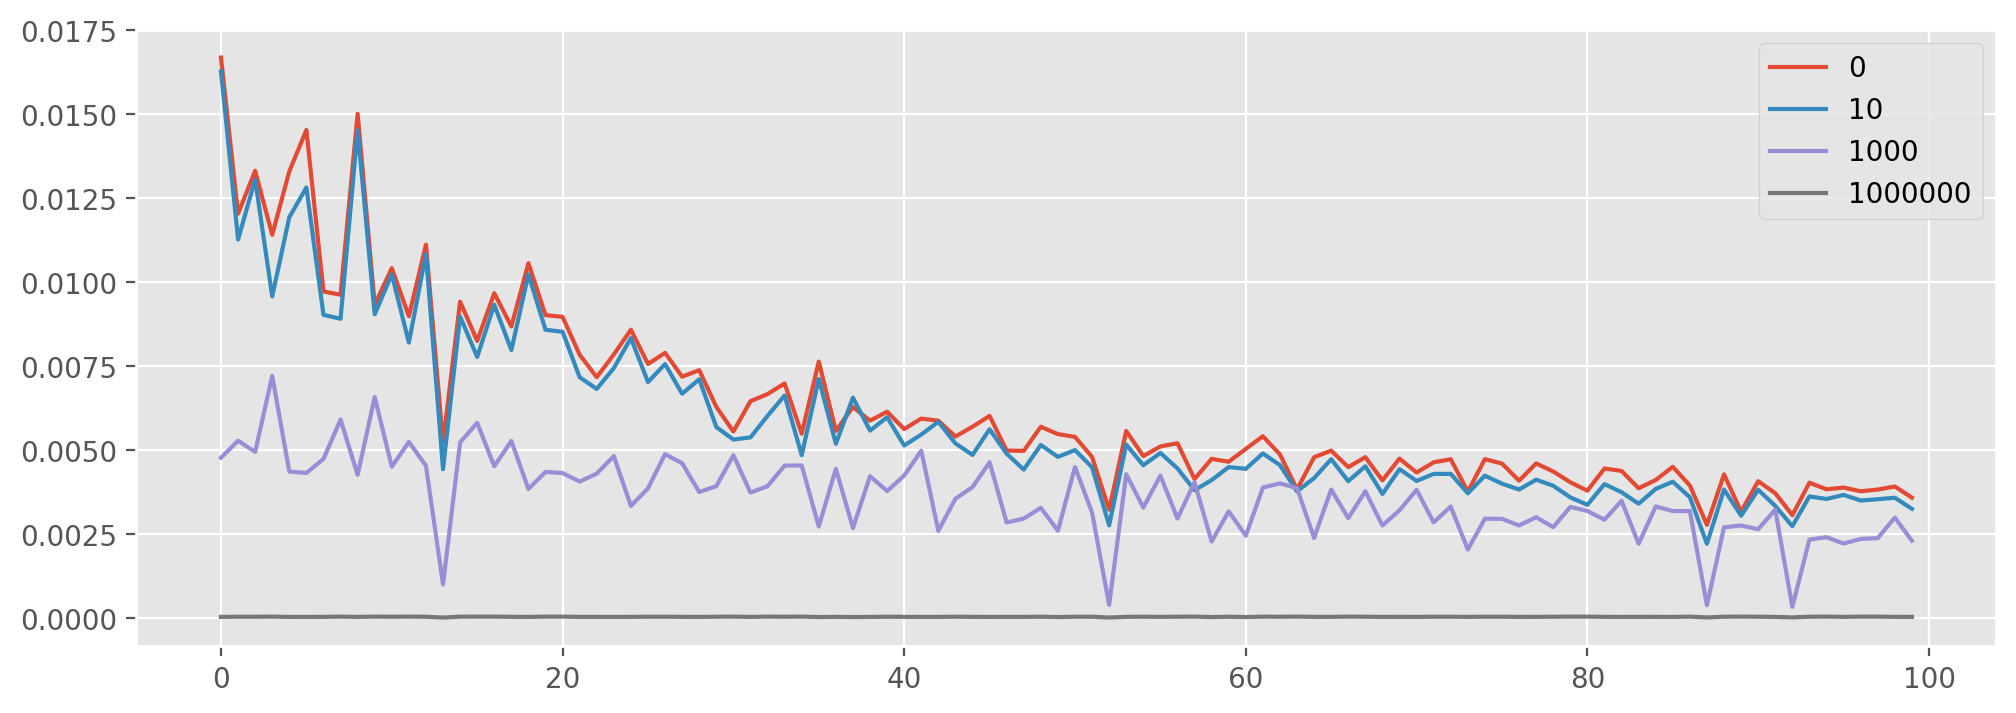

In [73]:
plt.figure(figsize=(12, 4))
for s in smooth_values:
    plt.plot(results[s]['df'].groupby('tree_index')['value'].std(), label=int(s))
plt.legend()    

In [25]:
results[0]['tree_stats'][0]

{'tree_idx': 0,
 'leaf_std': np.float64(0.017132388756288024),
 'leaf_range': 0.06337902311108756,
 'leaf_mean': np.float64(-4.105625511078406)}

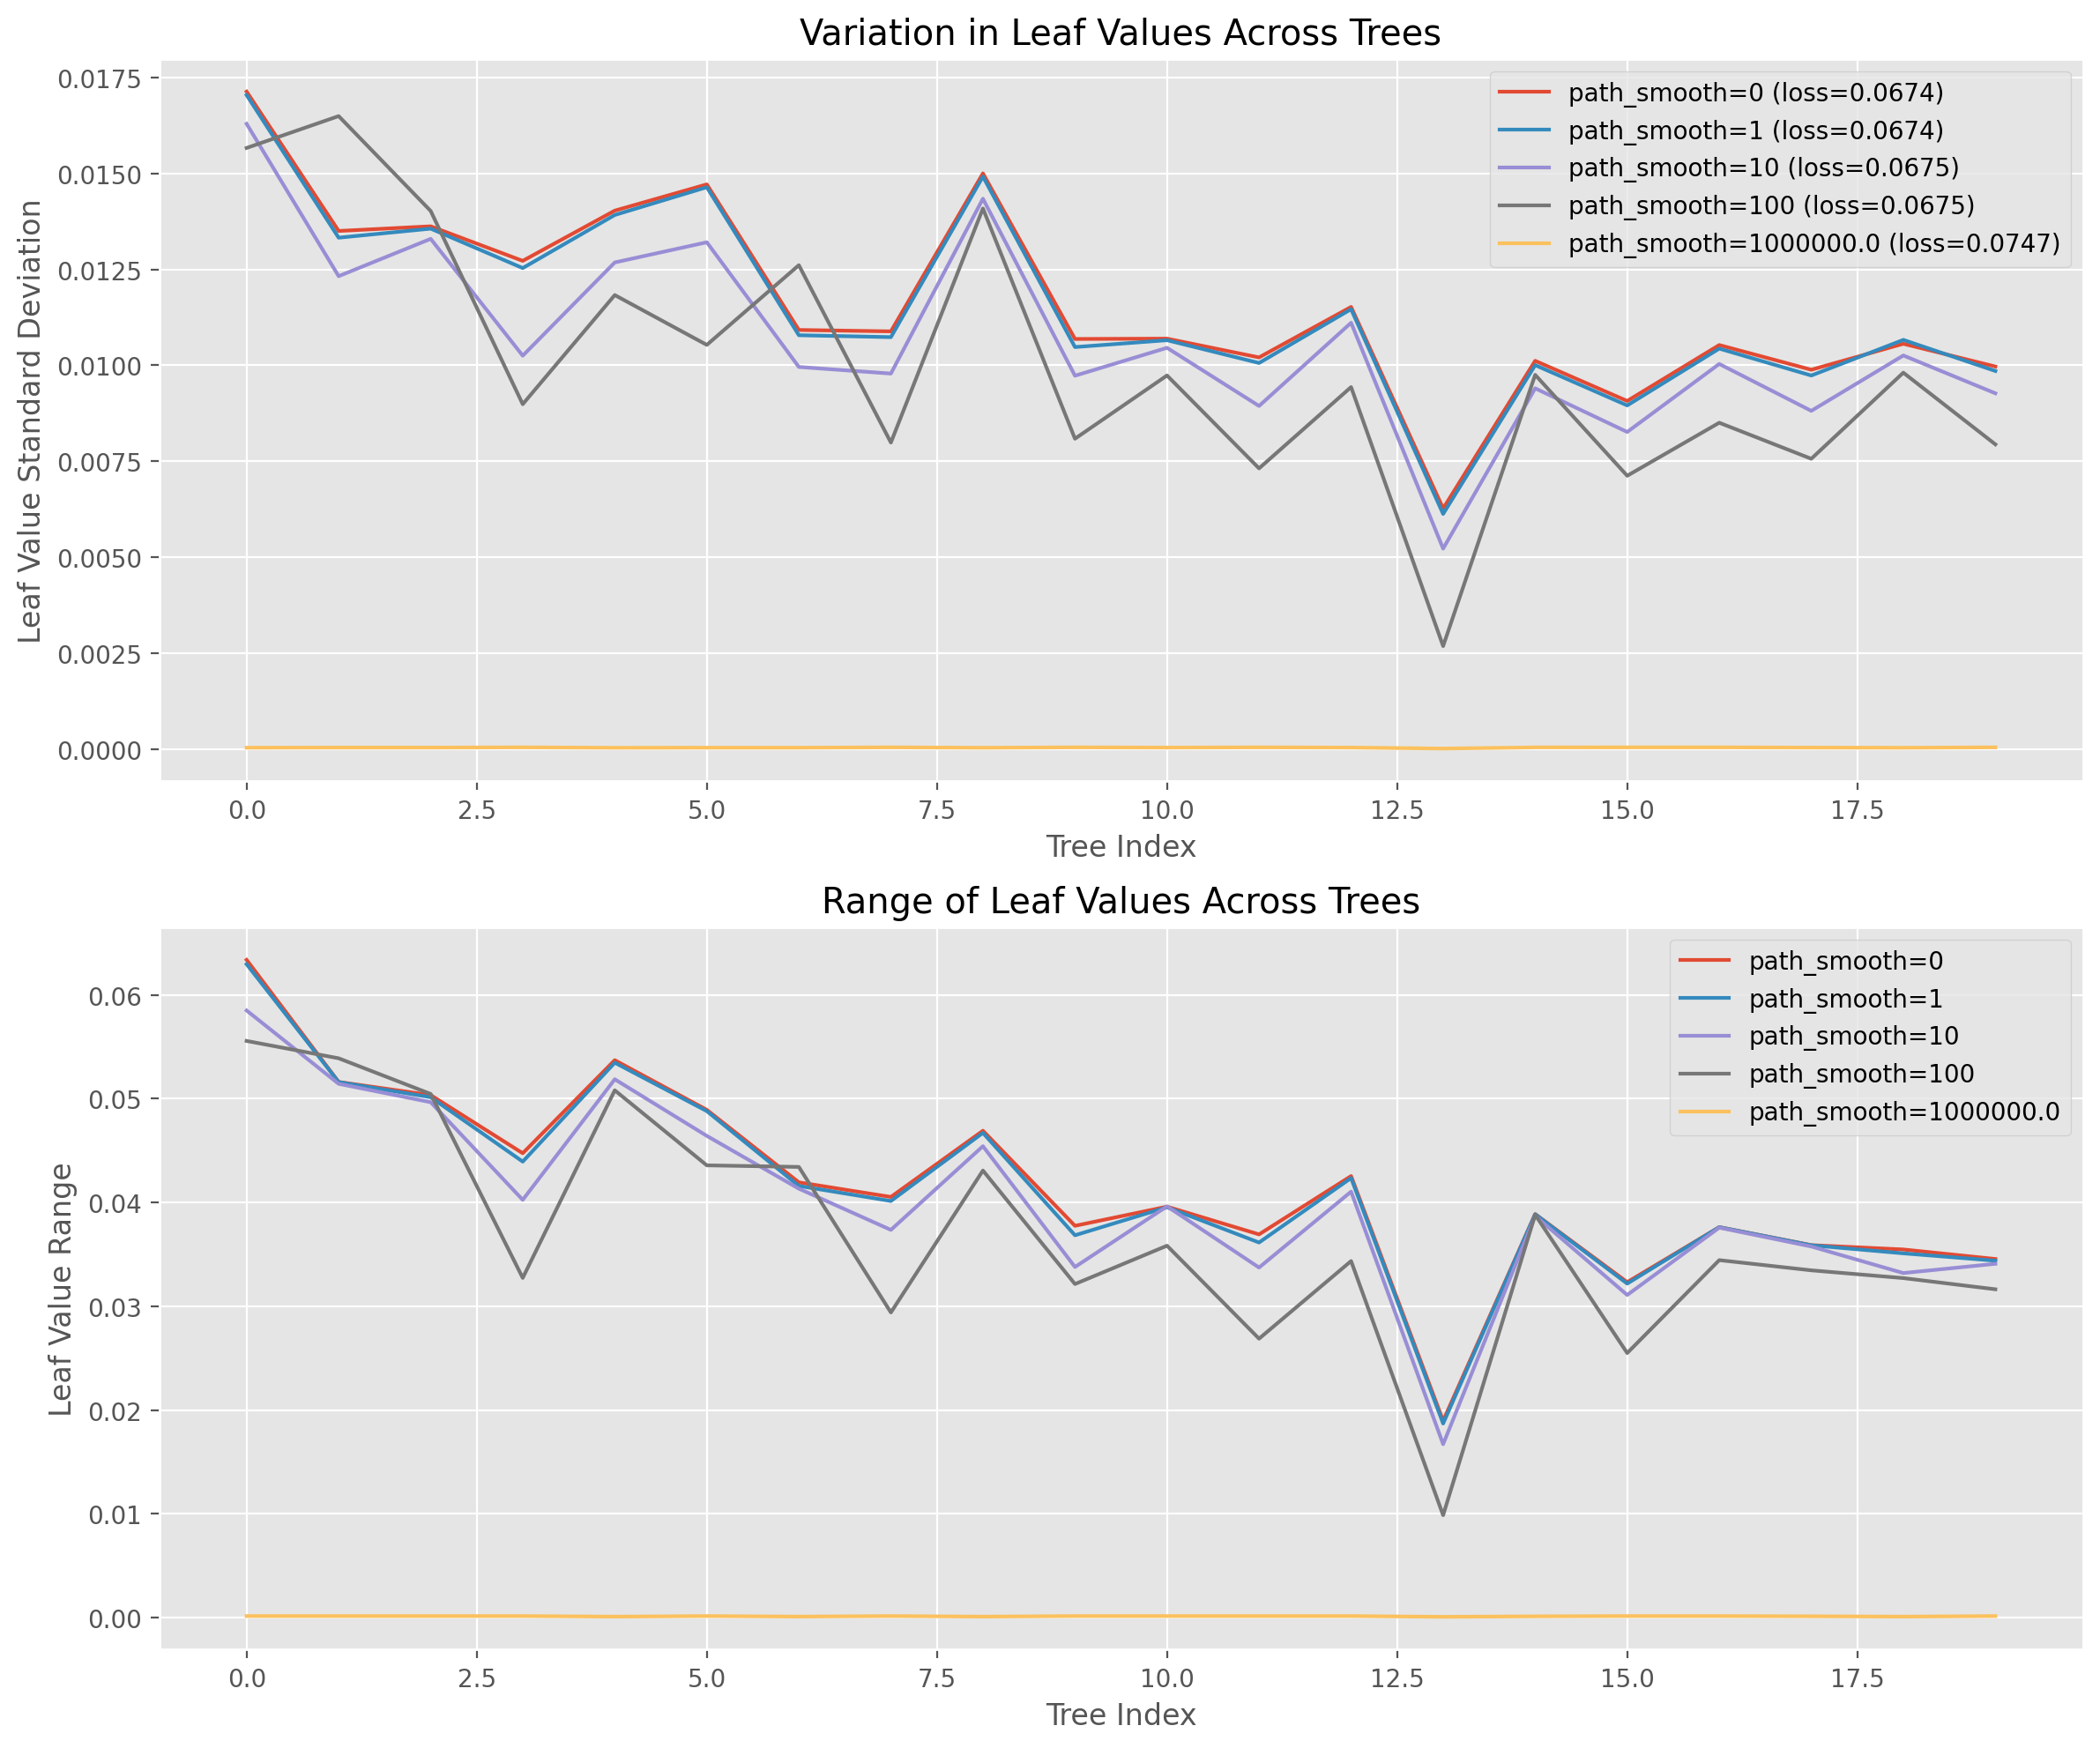

In [29]:
plot_leaf_stats(results)

In [26]:
def plot_leaf_stats(results):
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    for smooth, data in results.items():
        tree_indices = [s['tree_idx'] for s in data['tree_stats']]
        leaf_stds = [s['leaf_std'] for s in data['tree_stats']]
        leaf_ranges = [s['leaf_range'] for s in data['tree_stats']]
        
        axes[0].plot(tree_indices, leaf_stds, 
                    label=f'path_smooth={smooth} (loss={data["test_score"]:.4f})')
        axes[1].plot(tree_indices, leaf_ranges, 
                    label=f'path_smooth={smooth}')
    
    axes[0].set_xlabel('Tree Index')
    axes[0].set_ylabel('Leaf Value Standard Deviation')
    axes[0].set_title('Variation in Leaf Values Across Trees')
    axes[0].legend()
    
    axes[1].set_xlabel('Tree Index')
    axes[1].set_ylabel('Leaf Value Range')
    axes[1].set_title('Range of Leaf Values Across Trees')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_leaf_stats(results)

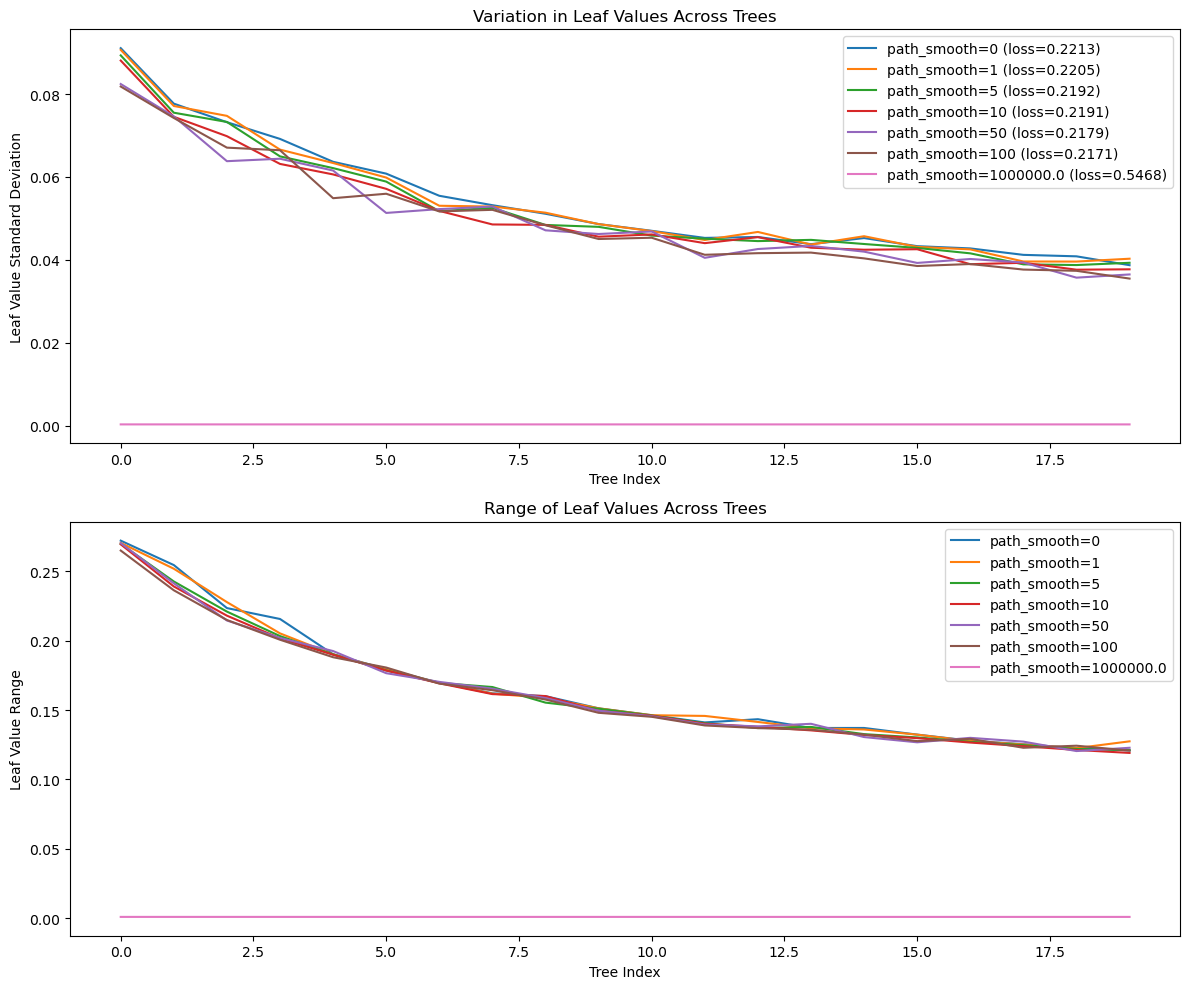


Summary statistics:

path_smooth = 0:
Average leaf std: 0.053891
Average leaf range: 0.165597
Test loss: 0.221316

path_smooth = 1:
Average leaf std: 0.053567
Average leaf range: 0.165368
Test loss: 0.220509

path_smooth = 5:
Average leaf std: 0.052521
Average leaf range: 0.163327
Test loss: 0.219181

path_smooth = 10:
Average leaf std: 0.051251
Average leaf range: 0.162421
Test loss: 0.219083

path_smooth = 50:
Average leaf std: 0.050153
Average leaf range: 0.163093
Test loss: 0.217887

path_smooth = 100:
Average leaf std: 0.049799
Average leaf range: 0.161902
Test loss: 0.217059

path_smooth = 1000000.0:
Average leaf std: 0.000345
Average leaf range: 0.000939
Test loss: 0.546757


In [13]:

def analyze_tree_path_values(model, max_trees=5):
    """Analyze leaf values along paths in the trees"""
    model_dump = model.dump_model()
    tree_stats = []
    
    for tree_idx, tree in enumerate(model_dump['tree_info'][:max_trees]):
        leaf_values = []
        
        def collect_leaf_values(node):
            if 'leaf_value' in node:
                leaf_values.append(node['leaf_value'])
            else:
                collect_leaf_values(node['left_child'])
                collect_leaf_values(node['right_child'])
        
        collect_leaf_values(tree['tree_structure'])
        
        stats = {
            'tree_idx': tree_idx,
            'leaf_std': np.std(leaf_values),
            'leaf_range': max(leaf_values) - min(leaf_values),
            'leaf_mean': np.mean(leaf_values)
        }
        tree_stats.append(stats)
    
    return tree_stats

def compare_path_smooth_effects(X_train, y_train, X_test, y_test, smooth_values=[0, 1, 1e6]):
    base_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'verbose': -1
    }

    # Create datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    results = {}
    for smooth in smooth_values:
        params = base_params.copy()
        params['path_smooth'] = smooth
        
        model = lgb.train(
            params, 
            train_data, 
            num_boost_round=100,
            valid_sets=[test_data]
        )
        
        # Analyze tree structures
        tree_stats = analyze_tree_path_values(model, max_trees=20)
        results[smooth] = {
            'tree_stats': tree_stats,
            'model': model,
            'test_score': model.best_score['valid_0']['binary_logloss']
        }
    
    return results

# Generate and prepare data
df = generate_synthetic_data()
X = df[['X1', 'X2']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run comparison
smooth_values = [0, 1, 5, 10, 50, 100, 1e6]
results = compare_path_smooth_effects(X_train, y_train, X_test, y_test, smooth_values)

# Plot leaf value statistics
def plot_leaf_stats(results):
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    for smooth, data in results.items():
        tree_indices = [s['tree_idx'] for s in data['tree_stats']]
        leaf_stds = [s['leaf_std'] for s in data['tree_stats']]
        leaf_ranges = [s['leaf_range'] for s in data['tree_stats']]
        
        axes[0].plot(tree_indices, leaf_stds, 
                    label=f'path_smooth={smooth} (loss={data["test_score"]:.4f})')
        axes[1].plot(tree_indices, leaf_ranges, 
                    label=f'path_smooth={smooth}')
    
    axes[0].set_xlabel('Tree Index')
    axes[0].set_ylabel('Leaf Value Standard Deviation')
    axes[0].set_title('Variation in Leaf Values Across Trees')
    axes[0].legend()
    
    axes[1].set_xlabel('Tree Index')
    axes[1].set_ylabel('Leaf Value Range')
    axes[1].set_title('Range of Leaf Values Across Trees')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Plot results
plot_leaf_stats(results)

# Print summary statistics
print("\nSummary statistics:")
for smooth in smooth_values:
    stats = results[smooth]['tree_stats']
    avg_leaf_std = np.mean([s['leaf_std'] for s in stats])
    avg_leaf_range = np.mean([s['leaf_range'] for s in stats])
    test_score = results[smooth]['test_score']
    
    print(f"\npath_smooth = {smooth}:")
    print(f"Average leaf std: {avg_leaf_std:.6f}")
    print(f"Average leaf range: {avg_leaf_range:.6f}")
    print(f"Test loss: {test_score:.6f}")

In [12]:
def analyze_gradient_bounds(N, class_ratio=0.5):
    """
    N: number of samples
    class_ratio: proportion of positive class (y=1)
    """
    n_pos = int(N * class_ratio)
    n_neg = N - n_pos
    
    # Total possible gradient range
    min_total = (-1 * n_pos) + (0 * n_neg)  # when all predictions are 0
    max_total = (0 * n_pos) + (1 * n_neg)   # when all predictions are 1
    
    # Average gradient range
    min_avg = min_total / N
    max_avg = max_total / N
    
    return {
        'total_range': (min_total, max_total),
        'average_range': (min_avg, max_avg),
        'per_sample_range': (-1, 1),
        'n_pos': n_pos,
        'n_neg': n_neg
    }

# Example
N = 100000
class_ratio = 0.001  # 30% positive class
bounds = analyze_gradient_bounds(N, class_ratio)

print(f"Dataset with {N} samples ({bounds['n_pos']} positive, {bounds['n_neg']} negative):")
print(f"Per-sample gradient range: {bounds['per_sample_range']}")
print(f"Total gradient range: {bounds['total_range']}")
print(f"Average gradient range: {bounds['average_range']}")

Dataset with 100000 samples (100 positive, 99900 negative):
Per-sample gradient range: (-1, 1)
Total gradient range: (-100, 99900)
Average gradient range: (-0.001, 0.999)
